# 🏦 Loan Status Prediction 📊  

The dataset used for this project is sourced from [Kaggle](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data), which contains various features related to loan applicants, including personal and financial information. The goal is to analyse these factors and build a predictive model to forecast the loan approval status (`loan_status`).

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split

from imblearn.over_sampling import SMOTE, SMOTENC
from scipy.stats import f_oneway, chi2_contingency

# Load the dataset
df = pd.read_csv('loan_data.csv')

## Dataset Overview

| **Column Name**                    | **Description**                                                                                                                                                 |
|-------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `person_age`                        | Age of the person.                                                                                                                                               |
| `person_gender`                     | Gender of the person.                                                                                                                                            |
| `person_education`                  | Highest level of education attained by the person.                                                                                                              |
| `person_income`                     | Annual income of the person.                                                                                                                                     |
| `person_emp_exp`                    | Years of employment experience.                                                                                                                                  |
| `person_home_ownership`             | Home ownership status (e.g., rent, own, mortgage).                                                                                                             |
| `loan_amnt`                         | Amount of the loan requested.                                                                                                                                     |
| `loan_intent`                       | Purpose of the loan (e.g., personal, mortgage, etc.).                                                                                                          |
| `loan_int_rate`                     | Interest rate on the loan.                                                                                                                                       |
| `loan_percent_income`               | Loan amount as a percentage of the person's annual income.                                                                                                     |
| `cb_person_cred_hist_length`        | Length of the person's credit history in years.                                                                                                                |
| `credit_score`                      | Credit score of the person.                                                                                                                                      |
| `previous_loan_defaults_on_file`    | Indicator of previous loan defaults (binary: 1 = defaulted, 0 = no defaults).                                                                                   |
| `loan_status (target variable)`     | Status of the loan approval: 1 = approved, 0 = rejected.                                                                                                        |

# Exploratory Data Analysis (EDA)

In [6]:
# Display dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

### 🔍 Observation 

The **person_age** column appears as a float, which is unusual since age is typically represented as an integer (whole number). This could be due to formatting or missing values in the dataset. The data should be converted to integers for proper analysis.


In [8]:
df.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561   
1                 0.08                         2.0           504   
2                 0.44                         3.0           635   
3                 0.44                         2.0           675   
4                 0.53                         4.0           586   

  previous_loan_defaults_on_file  loan_status  
0                             No            1  
1                            Yes            0  
2                             No            1  
3                             No            1  
4                             No            1

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [10]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

0

### Univariate Analysis

In [12]:
# Select the column names of all continuous variables (numerical data) from the DataFrame.
# This includes columns with data types 'float64' and 'int64'.
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns

# Select the column names of all categorical variables from the DataFrame.
# This includes columns with data types 'object' and 'category'.
categorical_vars = df.select_dtypes(include=['object', 'category']).columns

In [13]:
# Descriptive statistics for continuous variables
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns
continuous_summary = df[continuous_vars].describe()
continuous_summary

person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   4.500000e+04    45000.000000  45000.000000   
mean      27.764178   8.031905e+04        5.410333   9583.157556   
std        6.045108   8.042250e+04        6.063532   6314.886691   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.720400e+04        1.000000   5000.000000   
50%       26.000000   6.704800e+04        4.000000   8000.000000   
75%       30.000000   9.578925e+04        8.000000  12237.250000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000             0.070000                    3.000000   
50%        11.010000             0.120000                    4.000000   
75%        12.990000             0.190000                    8.000000   
max        20.000000             0.660000                   30.000000   

       credit_score   loan_status  
count  45000.000000  45000.000000  
mean     632.608756      0.222222  
std       50.435865      0.415744  
min      390.000000      0.000000  
25%      601.000000      0.000000  
50%      640.000000      0.000000  
75%      670.000000      0.000000  
max      850.000000      1.000000

### 🔍 Observations 

1. **Age Distribution:**  
   - The average age of applicants is 27.76 years, with most applicants aged between 24 and 30.  
   - There is a significant outlier with a maximum age of 144 years, which may indicate a data entry error.  

2. **Income Levels:**  
   - The median income is \\$67,048, with a wide range from \\$8,000 to \\$7.2M.  
   - The high maximum income suggests potential skewness in the distribution, possibly due to a few very high earners.  

3. **Employment Experience:**  
   - The average employment experience is 5.41 years, with most applicants having between 1 to 8 years of experience.  
   - The maximum value of 125 years is unrealistic and suggests potential data entry errors or anomalies that may require cleaning.  

4. **Loan Amounts:**  
   - Loan amounts range from \\$500 to \\$35,000, with a median of \\$8,000.  
   - The distribution appears right-skewed, meaning a few applicants are requesting significantly higher loans.  

5. **Credit History & Credit Scores:**  
   - The average credit history length is 5.87 years, with some applicants having up to 30 years of history.  
   - Credit scores range from 390 to 850, with a median of 640, meaning many applicants likely have fair to good credit.  

8. **Loan Approval Rate:**  
   - Only 22.2% of applicants were approved for loans (`loan_status = 1`). 

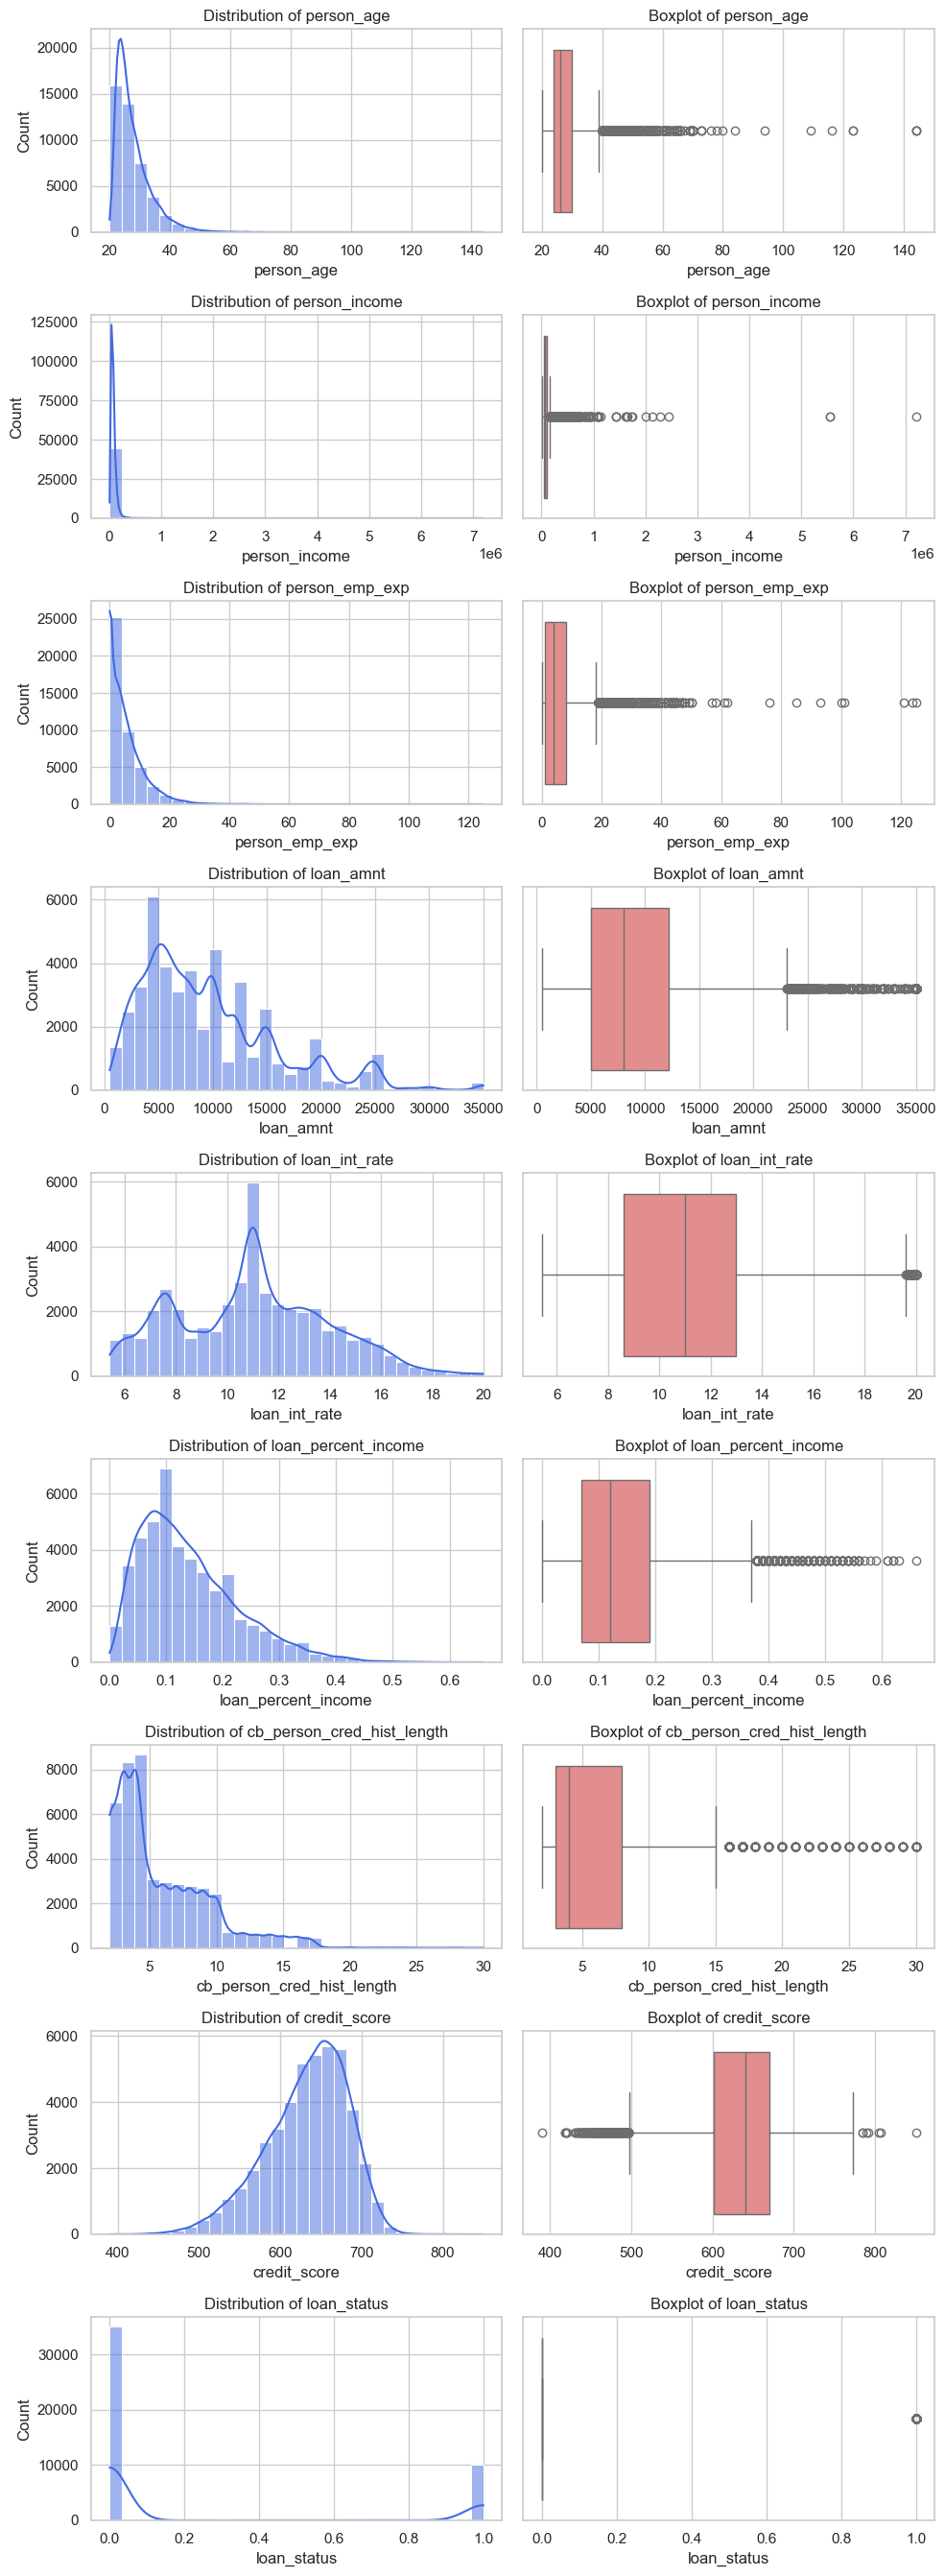

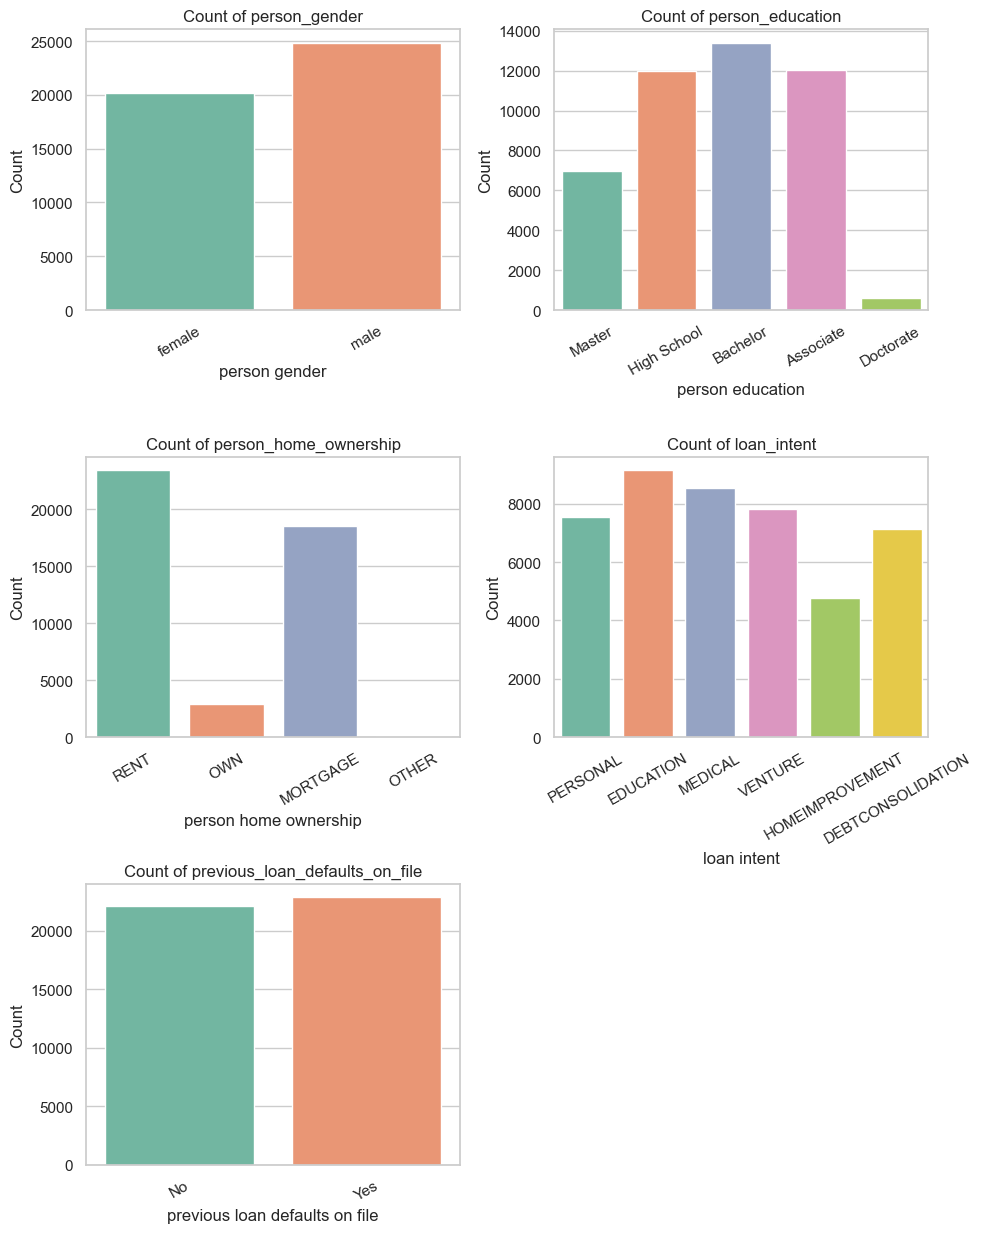

In [15]:
# Set visualization style
sns.set(style="whitegrid")

### Continuous Variables: Histograms & Boxplots 
fig, axes = plt.subplots(len(continuous_vars), 2, figsize=(10, len(continuous_vars) * 3))

for i, col in enumerate(continuous_vars):
    # Histogram
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 0], color="royalblue")
    axes[i, 0].set_title(f'Distribution of {col}')
    
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


### Categorical Variables: Count Plots 
fig, axes = plt.subplots(len(categorical_vars) // 2 + len(categorical_vars) % 2, 2, figsize=(10, len(categorical_vars) * 2.5))

for i, col in enumerate(categorical_vars):
    row, col_num = divmod(i, 2)  
    sns.countplot(x=df[col], hue=df[col], palette="Set2", ax=axes[row, col_num])
    axes[row, col_num].set_title(f'Count of {col}')
    axes[row, col_num].set_xlabel(col.replace('_', ' '))
    axes[row, col_num].set_ylabel("Count")
    axes[row, col_num].tick_params(axis='x', rotation=30)

# Remove empty subplots
for j in range(i + 1, len(axes.flat)):  
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

### 🔍 Observations

**Person Age (`person_age`):**

* **Distribution:** Skewed right, with the majority of data concentrated in younger ages.
* **Outliers:** Noticeable outliers are present at higher ages (above 80).

**Person Income (`person_income`):**

* **Distribution:** Highly skewed right, with most incomes concentrated near zero on the x-axis.
* **Outliers:** Presence of very high incomes, reaching into the millions, causing significant skewness.

**Person Employment Experience (`person_emp_exp`):**

* **Distribution:** Heavily right-skewed, with the majority of applicants having very little employment experience.
* **Outliers:** Significant outliers exist with very high employment experience values (up to 120+ years).

**Loan Amount (`loan_amnt`):**

* **Distribution:** Appears bimodal or multimodal, suggesting clusters of common loan amounts.
* **Outliers:** Some outliers are present on the higher end of loan amounts.

**Loan Interest Rate (`loan_int_rate`):**

* **Distribution:** Bimodal, suggesting two common interest rate ranges, possibly due to different loan types or risk assessments.
* **Outliers:** A few outliers are present at the higher end of the interest rate range.

**Loan Percent Income (`loan_percent_income`):**

* **Distribution:** Right-skewed, with most loans representing a small percentage of the applicant's income.
* **Outliers:** Numerous outliers are present at higher loan percent income values.
  
**Gender Distribution (`person_gender`):**
   - The dataset is heavily skewed towards male applicants.
   - There are significantly more male applicants than female applicants.

**Education Levels (`person_education`):**
   - The most common education levels are "High School" and "Bachelor".
   - "Doctorate" is the least represented education level.

**Home Ownership (`person_home_ownership`):**
   - "RENT" and "MORTGAGE" are the dominant home ownership categories.
   - "OWN" and "OTHER" are significantly less frequent.

**Loan Intent (`loan_intent`):**
   - "EDUCATION" and "MEDICAL" are the most frequent loan intents.
   - "HOMEIMPROVEMENT" is the least common loan intent.

**Previous Loan Defaults (`previous_loan_defaults_on_file`):**
   - The majority of applicants have previous loan defaults ("Yes").

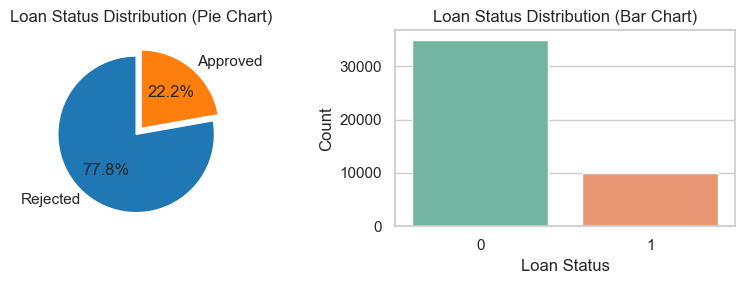

In [17]:
# Calculate the proportions for the pie chart
loan_status_proportions = df['loan_status'].value_counts(normalize=True)

# Create the pie chart
plt.figure(figsize=(8, 3))  
plt.subplot(1, 2, 1)  
loan_status_proportions.plot.pie(
    autopct='%1.1f%%',  
    labels=['Rejected', 'Approved'],  
    colors=['#1f77b4', '#ff7f0e'],  
    startangle=90,  
    explode=[0.1, 0]  
)
plt.title('Loan Status Distribution (Pie Chart)')
plt.ylabel('')  

# Create the countplot
plt.subplot(1, 2, 2)  # Subplot 2: Bar chart
sns.countplot(data=df, x='loan_status', hue='loan_status', palette='Set2', dodge=False, legend=False)
plt.title("Loan Status Distribution (Bar Chart)")
plt.xlabel("Loan Status")
plt.ylabel("Count")

# Show the combined plot
plt.tight_layout()  
plt.show()

### Bivariate Analysis
#### Continuous Variables: Loan Status Distribution

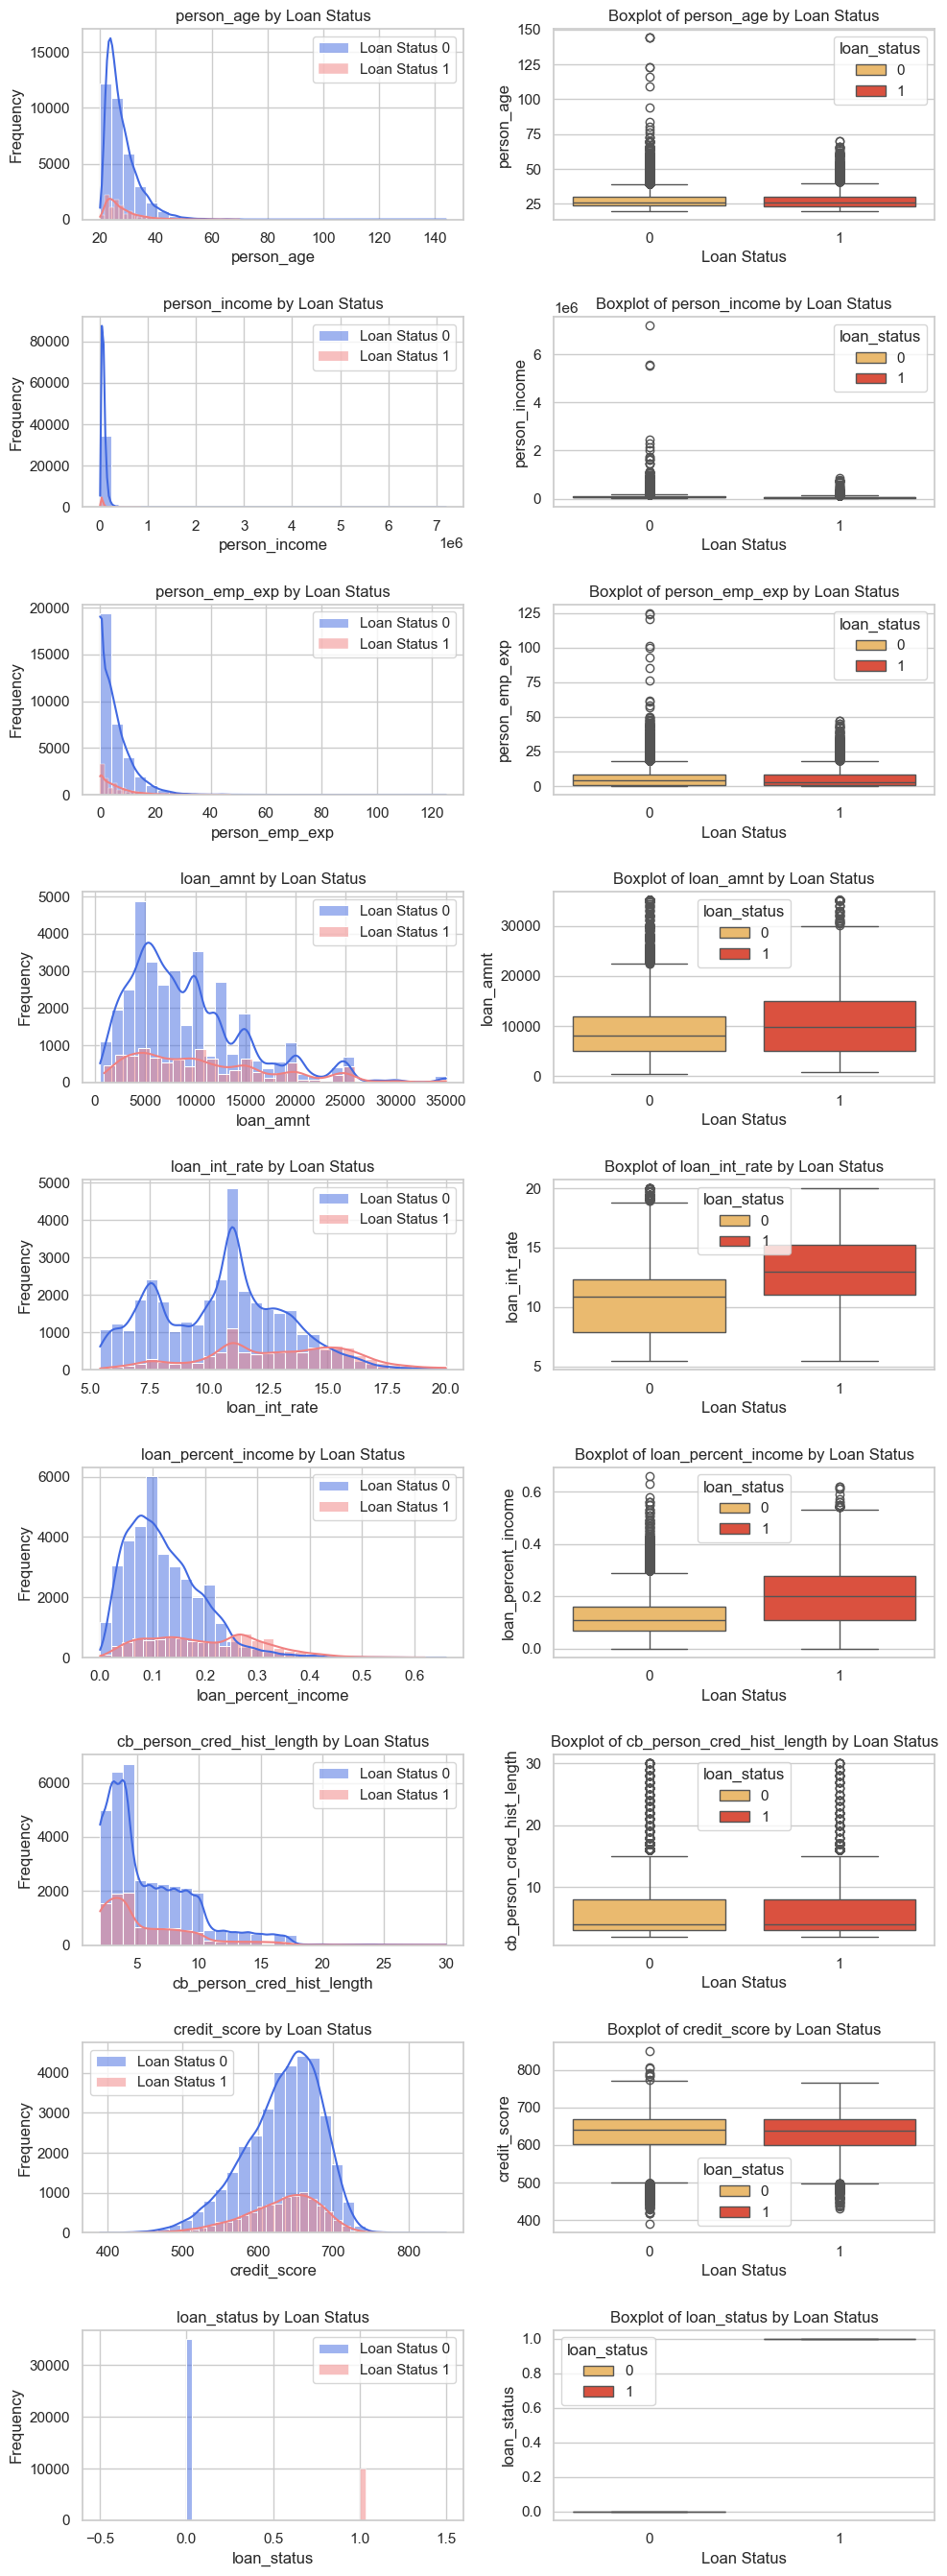

In [19]:
# Set visualization style
sns.set(style="whitegrid")

# Continuous Variables: Histograms by Loan Status
fig, axes = plt.subplots(len(continuous_vars), 2, figsize=(10, len(continuous_vars) * 3))

for i, col in enumerate(continuous_vars):
    # Histogram for each loan status category
    sns.histplot(df[df['loan_status'] == 0][col], bins=30, kde=True, ax=axes[i, 0], color="royalblue", label="Loan Status 0")
    sns.histplot(df[df['loan_status'] == 1][col], bins=30, kde=True, ax=axes[i, 0], color="lightcoral", label="Loan Status 1")
    axes[i, 0].set_title(f'{col} by Loan Status')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()

    # Boxplot for each loan status category 
    sns.boxplot(x='loan_status', y=col, data=df, ax=axes[i, 1], palette="YlOrRd", hue='loan_status')
    axes[i, 1].set_title(f'Boxplot of {col} by Loan Status')
    axes[i, 1].set_xlabel('Loan Status')
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.show()

### 🔍 Observations

- **Age**: Loan approvals and rejections follow similar age distributions, suggesting age alone may not be a strong predictor of loan approval. 
- **Income**: Loan approvals and rejections follow a similar distribution, but slightly higher-income individuals may have better approval chances.
- **Experience**: Employment experience does not strongly differentiate loan statuses, but high experience outliers are more common in denied loans.
- **Loan Amount**: Approved loans (Loan Status 1) tend to be for higher amounts. Denied loans (Loan Status 0) show a bimodal distribution, suggesting different loan amount preferences might influence denial.
- **Loan Interest Rate**: Higher interest rates surprisingly correlate with higher approval rates, potentially indicating riskier loans are approved more often.
- **Loan Percent Income**: Higher loan percent income (loan amount as a percentage of income) is clearly associated with loan approval (Loan Status 1), while lower loan percent income is more likely to result in loan denial (Loan Status 0).
- **Credit History Length**: Credit history length alone does not strongly differentiate approved and rejected loans, though very short histories (<5 years) are more common in rejected applications.
- **Credit Score**: While higher credit scores slightly improve loan approval chances, there is significant overlap between approved and rejected applicants, suggesting other factors influence loan decisions.

#### Categorical Variables: Loan Status by Categories

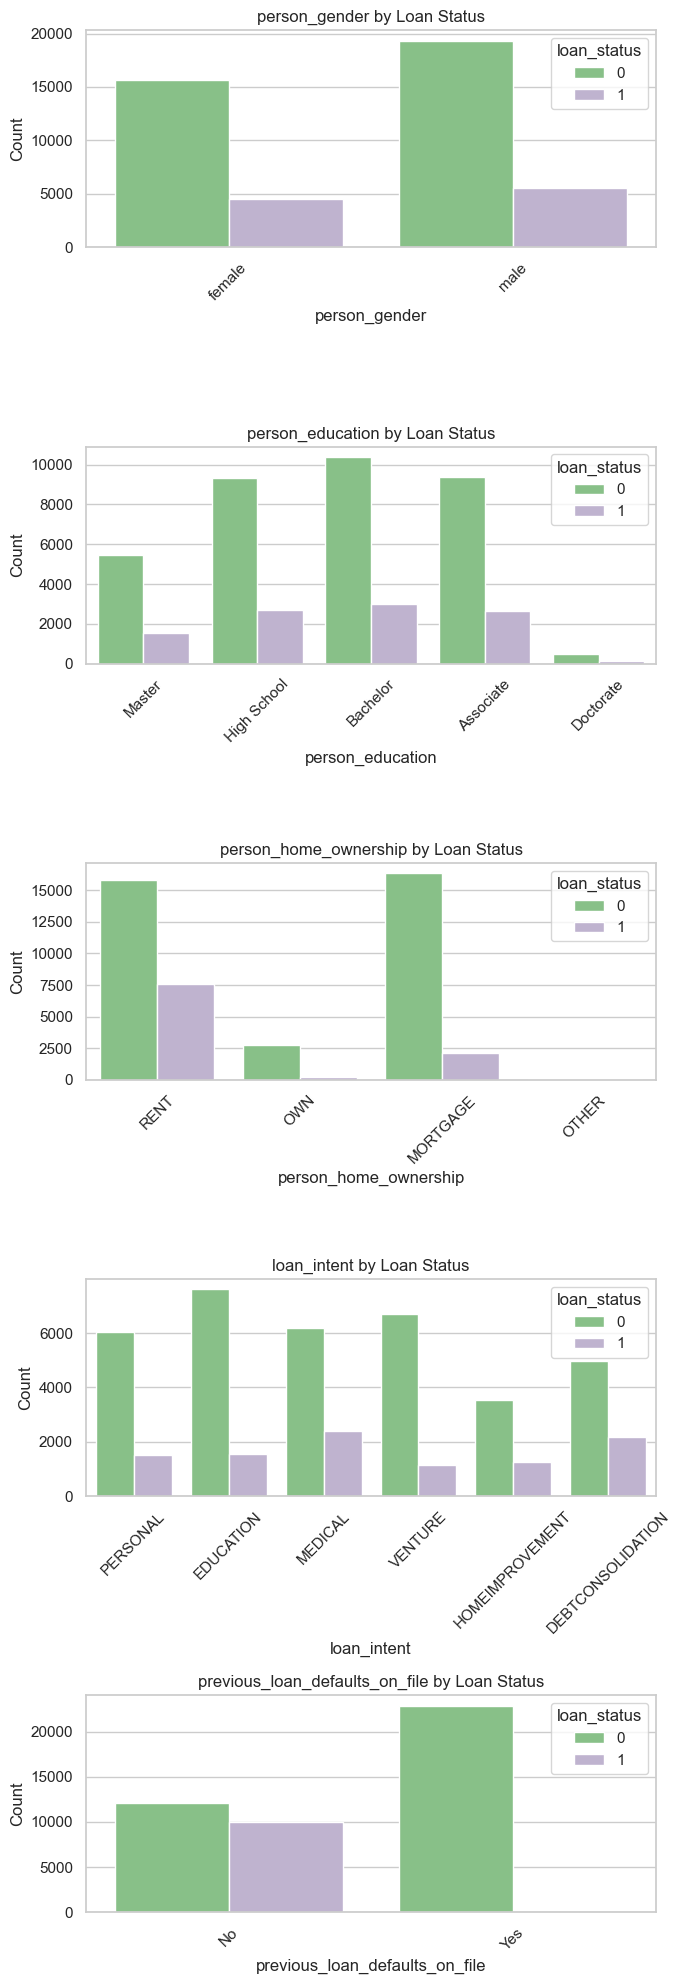

In [22]:
# Categorical Variables: Count Plots by Loan Status
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(7, len(categorical_vars) * 4))

for i, col in enumerate(categorical_vars):
    sns.countplot(data=df, x=col, hue='loan_status', palette="Accent", ax=axes[i])
    axes[i].set_title(f'{col} by Loan Status')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

In [23]:
# Store ANOVA test results in a DataFrame
anova_results = []
for col in continuous_vars:
    if col != 'loan_status':
        f_stat, p = f_oneway(df[df['loan_status'] == 0][col], df[df['loan_status'] == 1][col])
        anova_results.append([col, p])

anova_df = pd.DataFrame(anova_results, columns=["Feature", "P-Value"])
anova_df = anova_df.sort_values("P-Value")

# Store Chi-square test results in a DataFrame
chi2_results = []
for col in categorical_vars:
    if col != 'loan_status':
        contingency_table = pd.crosstab(df[col], df['loan_status'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        chi2_results.append([col, p])

chi2_df = pd.DataFrame(chi2_results, columns=["Feature", "P-Value"])
chi2_df = chi2_df.sort_values("P-Value")

# Display results
from IPython.display import display
print("\nANOVA Results (Continuous Variables):")
display(anova_df)  

print("\nChi-Square Results (Categorical Variables):")
display(chi2_df)  


ANOVA Results (Continuous Variables):


Feature        P-Value
4               loan_int_rate   0.000000e+00
5         loan_percent_income   0.000000e+00
1               person_income  3.483099e-184
3                   loan_amnt  3.236704e-116
0                  person_age   5.209774e-06
2              person_emp_exp   1.392337e-05
6  cb_person_cred_hist_length   1.630516e-03
7                credit_score   1.047627e-01


Chi-Square Results (Categorical Variables):


Feature        P-Value
2           person_home_ownership   0.000000e+00
4  previous_loan_defaults_on_file   0.000000e+00
3                     loan_intent  2.173084e-194
1                person_education   7.328269e-01
0                   person_gender   9.142540e-01

#### Correlation Analysis

##### NOVA Results (Continuous Variables)
- **Loan Interest Rate (`loan_int_rate`)**, **Loan Percent of Income (`loan_percent_income`)**, **Person Income (`person_income`)**, and **Loan Amount (`loan_amnt`)** all have p-values extremely close to 0. This suggests a very strong relationship with the dependent variable and should be considered significant predictors.
- **Person Age (`person_age`)** and **Person Employment Experience (`person_emp_exp`)** also show significant p-values (below 0.05), indicating that these variables likely contribute to the model.
- **Credit History Length (`cb_person_cred_hist_length`)** has a p-value below 0.05, suggesting it is a significant factor, though its effect is weaker than the others.
- **Credit Score (`credit_score`)** has a p-value of 0.1047, which is above the 0.05 threshold, indicating that it may not be a significant predictor when compared to other variables.

##### Chi-Square Results (Categorical Variables)
- **Person Home Ownership (`person_home_ownership`)** and **Previous Loan Defaults (`previous_loan_defaults_on_file`)** have p-values of 0, indicating a very strong association with the dependent variable and should be considered significant.
- **Loan Intent (`loan_intent`)** also has an extremely small p-value (close to 0), which points to its importance in the model.
- **Person Education (`person_education`)** and **Person Gender (`person_gender`)** have p-values of 0.7328 and 0.9143, respectively. These p-values suggest that these variables do not significantly influence the dependent variable in this context.

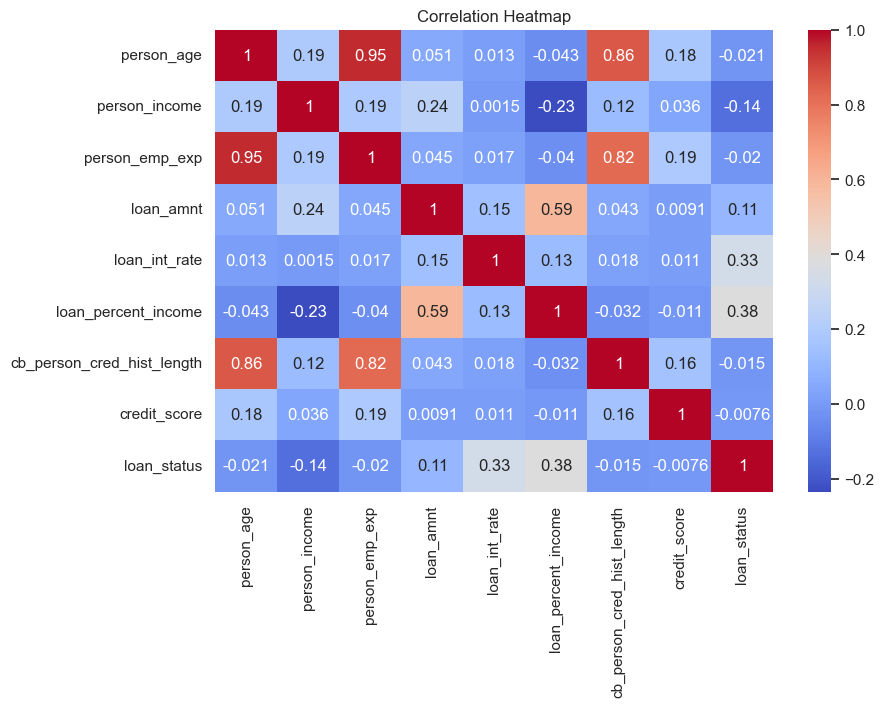

In [26]:
# Correlation Heatmap
correlation_matrix = df[continuous_vars].corr()
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

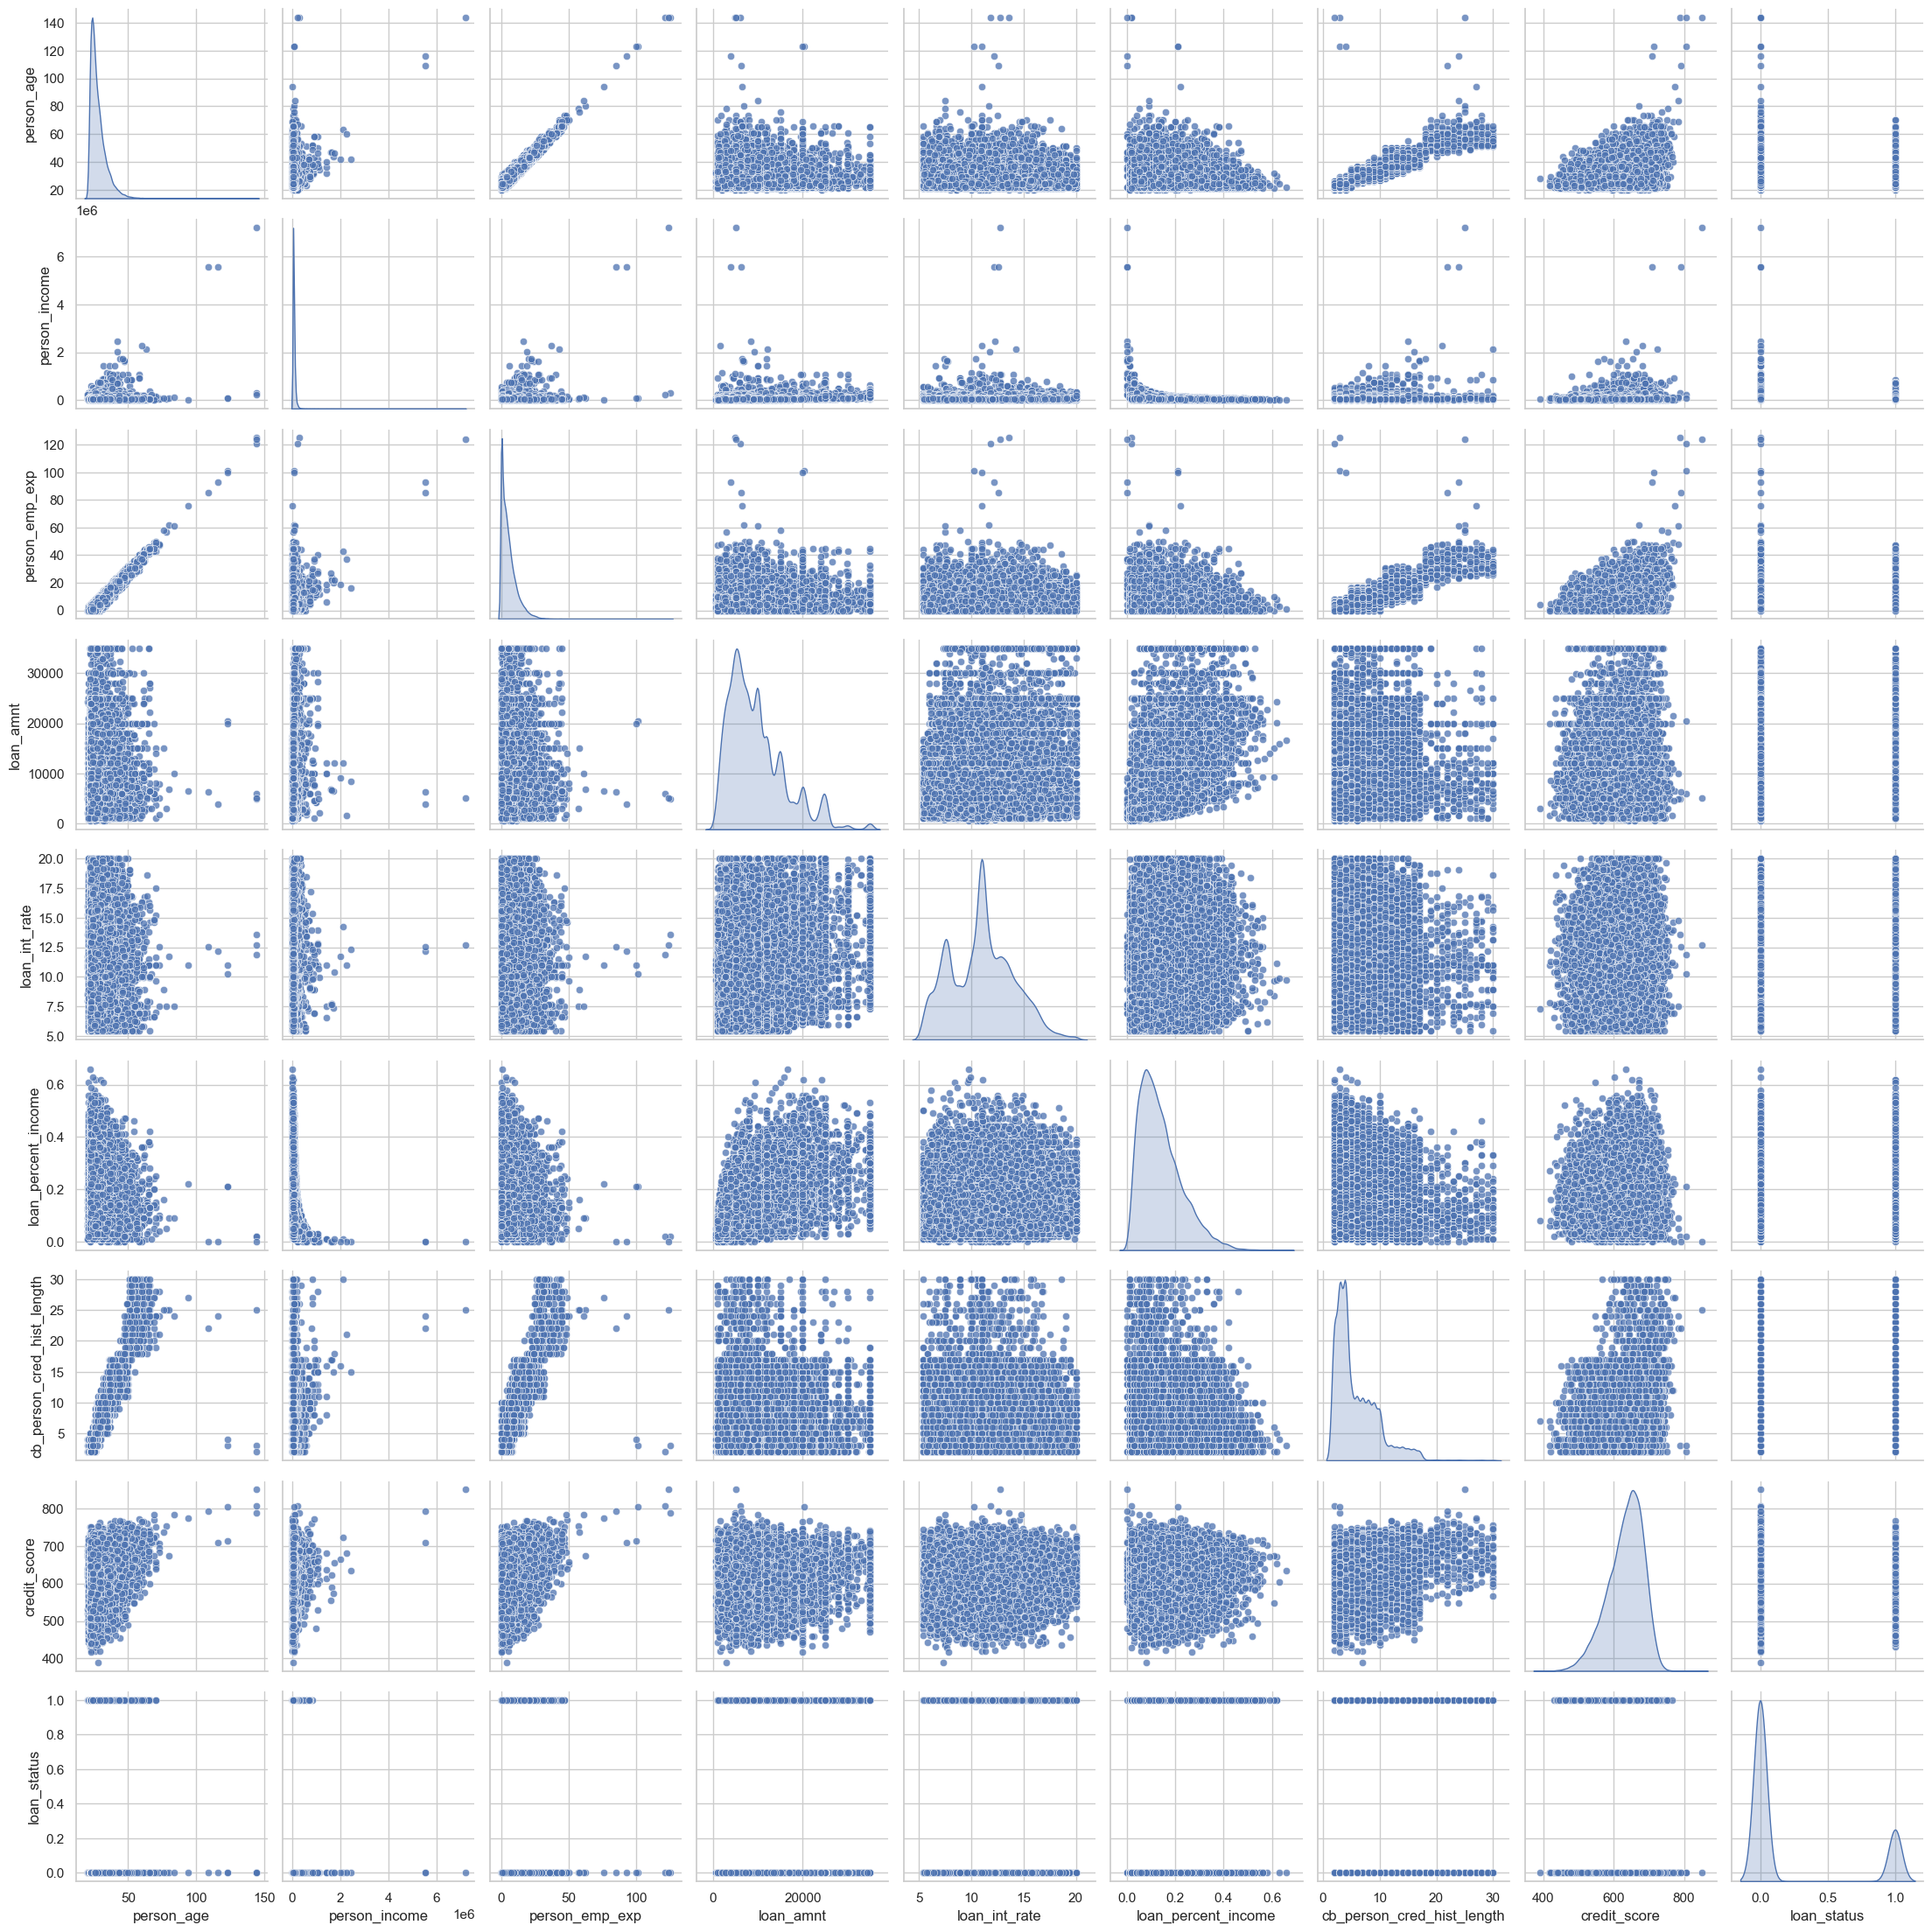

In [27]:
sns.pairplot(df[continuous_vars], diag_kind='kde', plot_kws={'alpha': 0.75})
plt.show()

### 🔍 Observations 

- **Age & Employment Experience (`0.95`)** → Older individuals tend to have more work experience.  
- **Credit History Length & Age (`0.86`), Employment Experience (`0.82`)** → Older applicants generally have longer credit histories.  
- **Loan Amount & Loan Percent Income (`0.59`)** → Higher loan amounts require a larger income percentage for repayments.  
- **Loan Status Correlations**  
  - **Loan Percent Income (`0.38`)**, **Loan Interest Rate (`0.33`)**, **Loan Amount (`0.11`)** → Loan percent income, interest rate, and loan amount might play a role in loan approval decisions to some extent. 
- **Income & Loan Percent Income (`-0.23`)** → Higher-income applicants allocate a smaller proportion to loan repayments.  

# Data Cleaning and Pre-processing

In [30]:
# Convert data type of 'person_age'
df['person_age'] = df['person_age'].astype(int)

In [31]:
print(df['person_age'].head())

0    22
1    21
2    25
3    23
4    24
Name: person_age, dtype: int64


In [32]:
# Cap 'person_age' at 100 years old
df['person_age'] = df['person_age'].apply(lambda x: min(x, 100))

In [33]:
df['person_age'].describe()

count    45000.000000
mean        27.759667
std          5.977583
min         20.000000
25%         24.000000
50%         26.000000
75%         30.000000
max        100.000000
Name: person_age, dtype: float64

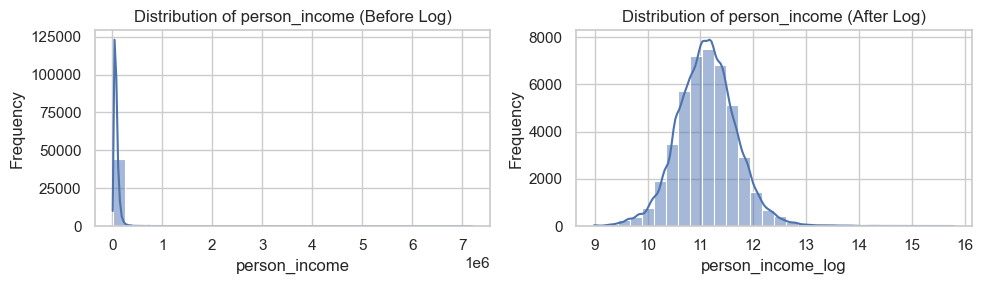

In [34]:
# Apply log transformation to handle skewness in 'person_income'

# Plot the distribution of 'person_income' before the log transformation
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.histplot(df['person_income'], kde=True, bins=30)
plt.title('Distribution of person_income (Before Log)')
plt.xlabel('person_income')
plt.ylabel('Frequency')

# Apply the log transformation
df['person_income_log'] = np.log(df['person_income'] + 1)

# Plot the distribution of 'person_income' after the log transformation
plt.subplot(1, 2, 2)
sns.histplot(df['person_income_log'], kde=True, bins=30)
plt.title('Distribution of person_income (After Log)')
plt.xlabel('person_income_log')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
# Calculate the median of the 'person_emp_exp' column
median_emp_exp = df['person_emp_exp'].median()

# Replace values in 'person_emp_exp' greater than 55 with the median value
df['person_emp_exp'] = df['person_emp_exp'].apply(lambda x: median_emp_exp if x > 55 else x)

**Rationale for Capping**: 
   - It's uncommon for individuals to have over 55 years of work experience, especially considering most people start their careers between 18-25 years old.
   - Values above 55 years are likely data entry errors or anomalies that do not represent the typical applicant profile.

Replace work experience values greater than 55 years with the median work experience to mitigate the impact of outliers on the model. The median is chosen to preserve the central tendency of the data and avoid introducing bias due to extreme values.

In [37]:
# Summary statistics to see if the outliers were replaced
print(df['person_emp_exp'].describe())

count    45000.000000
mean         5.387778
std          5.895324
min          0.000000
25%          1.000000
50%          4.000000
75%          8.000000
max         50.000000
Name: person_emp_exp, dtype: float64


In [38]:
# Feature Engineering

# Calculate the debt-to-income ratio: loan amount divided by person income
# Adding a small constant (1e-6) to avoid division by zero in case of zero income
df["debt_to_income_ratio"] = df["loan_amnt"] / (df["person_income"] + 1e-6)  

# Create a new feature 'age_group' by binning 'person_age' into categories
# The bins are: 0-25 (Young), 26-40 (Adult), 41-60 (Middle-Aged), and 61-100 (Senior)
df["age_group"] = pd.cut(df["person_age"], bins=[0, 25, 40, 60, 100], labels=["Young", "Adult", "Middle-Aged", "Senior"])

**Rationale for Feature Engineering**:
- The debt-to-income ratio is a financial metric used by lenders to evaluate an individual's ability to manage monthly payments and repay debts. A higher ratio may indicate a higher risk of default, making it a critical factor in determining loan approval.
- While the overall age distribution appears similar for approved and rejected loans, age may still have an indirect impact when combined with other factors such as financial history and income stability. For example, younger individuals might not have a stable financial history, while older individuals may have lower debt but a fixed income.

These newly added features, debt-to-income ratio and age group, could potentially help the model better capture relevant patterns in the data and improve its ability to predict loan approval outcomes.

In [40]:
# Encode categorical columns
label_encoder = LabelEncoder()

# For 'person_education' column 
df['person_education'] = label_encoder.fit_transform(df['person_education'])

# Revert 'person_education' to category type 
df['person_education'] = df['person_education'].astype('category')

# Encode other categorical variables using pd.get_dummies
nominal_data = ['person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file', 'person_gender', 'age_group']

# Apply pd.get_dummies to each categorical column
for col in nominal_data:
    encoded_df = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(columns=[col], inplace=True)

In [41]:
# Normalize/Scale Data
scaler = StandardScaler()
df[['person_income', 'loan_amnt', 'credit_score']] = scaler.fit_transform(
df[['person_income', 'loan_amnt', 'credit_score']]
)

In [42]:
# Min-Max Scaling for 'loan_int_rate'
min_max_scaler = MinMaxScaler()
df['loan_int_rate'] = min_max_scaler.fit_transform(df[['loan_int_rate']])

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   person_age                          45000 non-null  int64   
 1   person_education                    45000 non-null  category
 2   person_income                       45000 non-null  float64 
 3   person_emp_exp                      45000 non-null  float64 
 4   loan_amnt                           45000 non-null  float64 
 5   loan_int_rate                       45000 non-null  float64 
 6   loan_percent_income                 45000 non-null  float64 
 7   cb_person_cred_hist_length          45000 non-null  float64 
 8   credit_score                        45000 non-null  float64 
 9   loan_status                         45000 non-null  int64   
 10  person_income_log                   45000 non-null  float64 
 11  debt_to_income_ratio        

In [44]:
# Define features (X) and target (y)
X = df.drop('loan_status', axis=1)  
y = df['loan_status']

# Identify categorical columns for SMOTENC 
categorical_cols = [
    "person_home_ownership_OTHER", "person_home_ownership_OWN", "person_home_ownership_RENT", 
    "loan_intent_EDUCATION", "loan_intent_HOMEIMPROVEMENT", "loan_intent_MEDICAL", 
    "loan_intent_PERSONAL", "loan_intent_VENTURE", "previous_loan_defaults_on_file_Yes", 
    "person_education"
]

# SMOTE needs categorical columns as indices for non-continuous features
categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Apply SMOTE
smote = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['loan_status'] = y_resampled

# Verify the new class distribution
print(df_resampled['loan_status'].value_counts())

loan_status
1    35000
0    35000
Name: count, dtype: int64


## Model Building

In [46]:
# Split the resampled dataset into features (X) and target (y)
X_resampled = df_resampled.drop('loan_status', axis=1)
y_resampled = df_resampled['loan_status']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### Model Selection

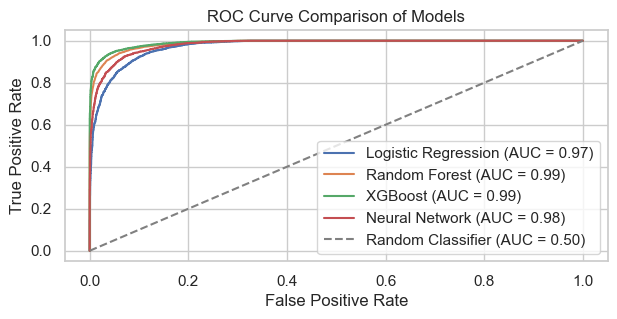

In [48]:
# Function to plot ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, label):
    # Get the predicted probabilities
    y_prob = model.predict_proba(X_test)[:, 1]  # Only need the probabilities for the positive class

    # Calculate false positive rate (FPR), true positive rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# Initialize and train the models
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

xgb_clf = xgb.XGBClassifier(random_state=42, enable_categorical=True)
xgb_clf.fit(X_train, y_train)

mlp_clf = MLPClassifier(random_state=42, max_iter=1000)
mlp_clf.fit(X_train, y_train)

# Plot ROC curve for each model
plt.figure(figsize=(7, 3))

plot_roc_curve(logreg, X_test, y_test, 'Logistic Regression')
plot_roc_curve(rf_clf, X_test, y_test, 'Random Forest')
plot_roc_curve(xgb_clf, X_test, y_test, 'XGBoost')
plot_roc_curve(mlp_clf, X_test, y_test, 'Neural Network')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.50)')

# Customize the plot
plt.title('ROC Curve Comparison of Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

### ROC Curve Comparison of Models

- **Random Forest (AUC = 0.99)** and **XGBoost (AUC = 0.99)** exhibit the highest performance, closely following the ideal classifier.
- **Neural Network (AUC = 0.98)** also performs well, slightly below the tree-based models.
- **Logistic Regression (AUC = 0.97)** demonstrates strong performance but is outperformed by ensemble models.
- The **Random Classifier (AUC = 0.50)** serves as a baseline, representing random guessing.

In [50]:
# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Predict using the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9394

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7023
           1       0.93      0.95      0.94      6977

    accuracy                           0.94     14000
   macro avg       0.94      0.94      0.94     14000
weighted avg       0.94      0.94      0.94     14000



In [51]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(random_state=42, enable_categorical=True, eval_metric='logloss')

# Train the model
xgb_clf.fit(X_train, y_train)

# Predict using the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9483

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7023
           1       0.95      0.95      0.95      6977

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



Based on the results:

- **XGBoost** achieved a higher accuracy of **0.95**, compared to **Random Forest's** **0.94**.
- **XGBoost** showed better precision, recall, and F1-score across both classes (**0.95** vs **0.93-0.95** for Random Forest).

Thus, **XGBoost** provides slightly better performance overall.

### Hyperparameter Tuning

In [54]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters 
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}


### Evaluation Metrics

In [56]:
# Train the best model with the best parameters found
best_xgb = XGBClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    learning_rate=grid_search.best_params_['learning_rate'],
    colsample_bytree=grid_search.best_params_['colsample_bytree'],
    subsample=grid_search.best_params_['subsample'],
    random_state=42,
    eval_metric='logloss',
    enable_categorical=True
)

# Fit the model with the training data
best_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)

# Evaluate the model
train_accuracy = best_xgb.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)

# Print accuracy comparison
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Check for overfitting based on accuracy difference
if train_accuracy - test_accuracy > 0.05:
    print("The model might be overfitting")
else:
    print("No signs of overfitting. The model generalizes well.")

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.991875
Test Accuracy: 0.9502857142857143
No signs of overfitting. The model generalizes well.
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      7023
           1       0.95      0.95      0.95      6977

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000

